The goal of this notebook is to train to classify whether a Bashkir-Russian sentence pair is a correct translation. 

I am going to try the following configurations
+ **Just BERT classifier training on the whole training data** => cannot go above 80% of ROC AUC (or 56% recall @ rejecting n_bad)
    - need to start training softly, otherwise it goes very unstable
    - setting 300K instead of 100K training steps does not help much, at least in this configuration
- Training on the positive data only, with contrastive artificial negatives
- Training on the whole training data + MLM 


Heavily inspired by https://github.com/slone-nlp/myv-nmt/blob/main/dirty-code-2022/model_training/02_pretrain_sentence_encoder.ipynb

In [1]:
import pandas as pd
import numpy as np

import torch
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [32]:
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score

In [9]:
from transformers.optimization import Adafactor
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

In [3]:
data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')

data.data_split.value_counts()

train    104317
test      35648
dev       34998
val        1743
Name: data_split, dtype: int64

In [4]:
data_train = data[data.data_split=='train']
data_val = data[data.data_split=='val']
data_train.sample(3)

,date,ba,ru,is_correct,data_split
64100,01/08/2022 07:57:33,Ике яҡтан ҡыҫырға.,Зажать с двух сторон.,1,train
140408,01/10/2021 16:52:23,Кисә мәрәкә булды.,Громко-громко.,0,train
102668,16/11/2022 01:00:18,– Хәбирйән теҙҙән юғары уң аяғын өҙҙөрөп ҡайтҡан.,"– Ногу ему оторвало, выше колена.",1,train


# Loading the model

In [7]:
def get_pairs_batch(bs=4):
    batch = data_train.sample(bs)
    pp = [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [row.is_correct for row in batch.itertuples()]
    return [list(t) for t in zip(*pp)], labels

In [5]:
base_model = 'bert-base-multilingual-cased'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(base_model)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [36]:
model.cuda();

In [37]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [13]:
data_train.sample(3)

,date,ba,ru,is_correct,data_split
114283,23/12/2022 18:17:16,"— Бер мыҫҡыл ителгәс, ҡайҙа бараһың.",— Коли надругались над тобой – куда пойдешь?,1,train
98233,02/11/2022 19:43:25,"Ҡарап сыҡтым, Рауил, дәфтәреңде,","Я просмотрел, Равиль, твою тетрадь,",1,train
22964,11/10/2021 16:10:16,– Бына егеттәр менән эҙләп тап уларҙы.,– Вот с егетами поищи их.,1,train


In [27]:
get_pairs_batch()

([['Долорес – Педро Зуританың әсәһе.',
   '— Бына һиңә бүләккә бүре тиреһе, дуҫ.',
   'Өсөнсөгә уҡыйым: «һаумыһығыҙ, Нурия!',
   'Ул кискә табан ғына Кесе Йөҙҙән ҡайтып төштө. Ҡәйепхан саҡырта, тип киткәйне.'],
  ['Долорес – мать Педро Зуриты.',
   'Шкура волка...',
   'Читаю в третий раз: «Здравствуй, Нурия!',
   'Он только к вечеру вернулся, к Каип-хану вроде ездил.']],
 [1, 0, 1, 1])

In [90]:
s = data_train.sample(100)
tokenizer(s.ru.tolist(), s.ba.tolist(), return_tensors='pt', padding=True).input_ids.shape

torch.Size([100, 211])

# Training

In [28]:
loss_fn = torch.nn.CrossEntropyLoss()

In [30]:
losses = []

In [95]:
batch_size = 3
report_steps = 100

In [107]:
model.train()
tq = trange(len(losses), 100_000)
for i in tq:
    pp, pl = get_pairs_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=256, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/14903 [00:00<?, ?it/s]

85100 0.5634452274919022
error 381
85200 0.4859878540260252
85300 0.6221928421640769
error 347
85400 0.5326563806505874
error 400
85500 0.7456432548468002
85600 0.5481290923932102
85700 0.5522675605549011
85800 0.530933350949781
85900 0.5577959369414021
86000 0.6402862130943686
86100 0.5114235010324046
error 501
86200 0.7231354623497463
86300 0.5595385519857519
86400 0.7032568179047667
86500 0.6241817859036383
86600 0.6997567939618602
86700 0.481231059540296
86800 0.5351923632319086
86900 0.501218625700567
error 443
87000 0.6834038704668637
87100 0.7407034175680018
87200 0.5290789725037758
87300 0.5873091683688108
87400 0.6957285688130651
87500 0.5409586527571082
error 357
87600 0.553155846366426
87700 0.41123589739087035
87800 0.5456288456881885
87900 0.43831693882064426
88000 0.6826937043829822
88100 0.6227974848577287
88200 0.49634585151914506
error 424
88300 0.6921446068491787
error 561
88400 0.5856656018795912
88500 0.5804597095330246
error 433
88600 0.4748885283153504
88700 0.585

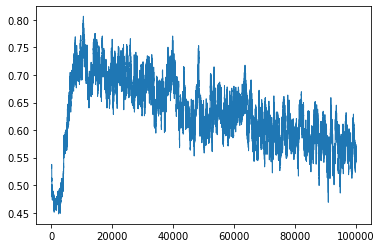

In [133]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [117]:
from sklearn.metrics import roc_auc_score

In [118]:
loss = None
cleanup()
model.eval();

In [119]:
eval_bs = 16

In [120]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())

  0%|          | 0/109 [00:00<?, ?it/s]

In [127]:
logits = np.array(logits)

In [121]:
print(roc_auc_score(data_val.is_correct, logits))

0.8171253420533107


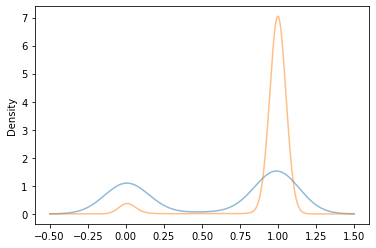

In [126]:
pd.Series(logits, index=data_val.index).groupby(data_val.is_correct).plot(alpha=0.5, kind='kde');

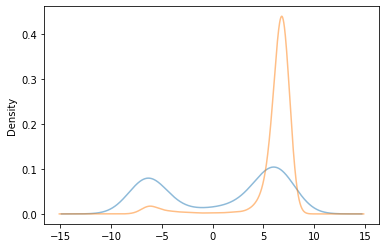

In [131]:
pd.Series(np.log(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(alpha=0.5, kind='kde');

In [134]:
model.save_pretrained('../models/bak-ru-cross-v0')

# Stabilize the traning by starting slow

The quality is not very good, and the model seems to have broken on about 5k steps. 

Maybe, we could have avoided it by gentler learning?

In [156]:
model, loss, optimizer = None, None, None
cleanup()

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(base_model).cuda();

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [11]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

In [12]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-4, clip_threshold=1.0
)
cleanup()

In [13]:
losses = []

In [14]:
head_steps = 5_000
batch_size = 8
report_steps = 100
train_max_length = 256

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=head_steps)

In [18]:
model.train()
tq = trange(len(losses), head_steps)
for i in tq:
    pp, pl = get_pairs_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/5000 [00:00<?, ?it/s]

0 0.7860291600227356
100 0.7298102509975434
200 0.7018184030056
300 0.6634465360641479
400 0.6110372769832612
500 0.5731197443604469
600 0.5292658033967018
700 0.5366545644402504
800 0.512962621152401
900 0.5255114856362343
1000 0.5245824012160302
1100 0.4998550970852375
1200 0.5290006640553474
1300 0.5493460766971111
1400 0.5112707488238811
1500 0.5297019925713539
1600 0.4918939134478569
1700 0.525192865729332
1800 0.5216489689052105
1900 0.527722498178482
2000 0.5338441878557205
2100 0.5345318272709847
2200 0.5379093755781651
2300 0.5398297165334225
2400 0.5208286373317241
2500 0.5053238946199418
2600 0.5193827359378338
2700 0.5398142835497857
2800 0.48453920900821684
2900 0.49615797996520994
3000 0.5440157420933247
3100 0.5117940230667591
3200 0.5116272021830082
3300 0.5084193442761898
3400 0.49047269210219385
3500 0.5094666042923928
3600 0.48238864794373515
3700 0.49442910090088843
3800 0.5246364273130893
3900 0.5057592914998531
4000 0.5180430409312248
4100 0.5248226764798164
4200 

Loss of about 53% corresponds to the loss of predicting the constant correctness probability of 0.778; our model seems to be only marginally better. 

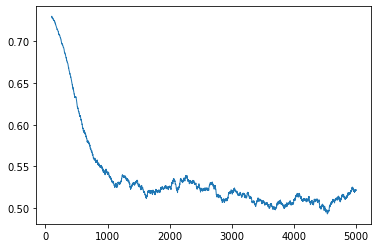

In [19]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [20]:
for p in model.parameters():
    p.requires_grad = True

In [21]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [22]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

In [23]:
full_steps = 95_000
batch_size = 3
report_steps = 100
train_max_length = 256

In [24]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=full_steps)

In [41]:
model.train()
tq = trange(len(losses), head_steps + full_steps)
for i in tq:
    pp, pl = get_pairs_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/83385 [00:00<?, ?it/s]

error 314
16700 0.4128253572806716
16800 0.5281504969298839
16900 0.4214088296890259
17000 0.44270123705267905
17100 0.3986013529449701
17200 0.39962582059204577
17300 0.5326347465068102
17400 0.4537380376458168
17500 0.3465457621216774
17600 0.42802059777081014
17700 0.46252988785505295
17800 0.4345121466368437
17900 0.4087757542729378
18000 0.4362809782475233
18100 0.4162318510562181
18200 0.4160701421648264
18300 0.4397097094729543
18400 0.40132328048348426
18500 0.4326487200334668
18600 0.3895001047477126
18700 0.47839942008256914
18800 0.43821532391011714
18900 0.4075763691216707
19000 0.3803430821746588
19100 0.5523766597360372
19200 0.4484780661016703
19300 0.3938522196188569
19400 0.43521639209240676
19500 0.4831412653625011
19600 0.45452289685606956
19700 0.4426114423573017
19800 0.4753516283631325
19900 0.47655112609267236
20000 0.41492323964834216
20100 0.37774875342845915
20200 0.3833996857330203
20300 0.45283726274967195
20400 0.4810756807029247
20500 0.48544173255562784
2

48600 0.36137531768530606
48700 0.3040342254564166
48800 0.38495249185711145
48900 0.38751018434762957
49000 0.39779280487447977
49100 0.37452509231865405
49200 0.36559606429189445
49300 0.3788582457229495
49400 0.40095090478658674
49500 0.28811798986047504
49600 0.39214164908975363
49700 0.3549158776178956
49800 0.3529487057030201
49900 0.36440810084342956
50000 0.39383424788713456
50100 0.3849256632477045
50200 0.3706568498909473
50300 0.41688138116151097
50400 0.34206604696810244
50500 0.3528482889011502
50600 0.3262054653093219
50700 0.44418232709169386
50800 0.406664969176054
50900 0.3777662004902959
error 283
51000 0.3736004309356213
51100 0.30454114627093076
51200 0.3241076657921076
51300 0.34008117962628603
51400 0.31510162383317947
51500 0.38826020862907173
51600 0.3361215602979064
51700 0.31219092577695845
51800 0.3083719833195209
51900 0.3015259163454175
52000 0.3458189037814736
52100 0.31850168462842704
52200 0.4202496264129877
52300 0.37050889126956466
52400 0.291812570802

80700 0.30227259527891875
80800 0.37602043107151983
80900 0.32981730248779056
error 308
error 283
81000 0.25607448525726795
81100 0.36468476835638286
81200 0.2980784192681313
81300 0.33679519083350895
81400 0.3483488804847002
81500 0.36179141499102113
81600 0.29804510716348886
81700 0.31011890459805724
81800 0.316392868719995
81900 0.33714216977357864
82000 0.36522617112845185
82100 0.25826315820217133
82200 0.33600585836917163
82300 0.24106498781591654
82400 0.2793187292665243
82500 0.32695550806820395
82600 0.26212846759706737
82700 0.25825541574507954
82800 0.2784401112794876
82900 0.23600163884460926
83000 0.2554223427176476
83100 0.39603114042431115
83200 0.2141304696723819
83300 0.2952071052789688
83400 0.2766094080731273
83500 0.28853694774210453
83600 0.33262613739818336
83700 0.3355277014523745
83800 0.37386101704090835
83900 0.27682972233742476
84000 0.2748968552052975
84100 0.3488462774828076
84200 0.32070662029087543
84300 0.3295535318180919
84400 0.3806175534054637
84500 0

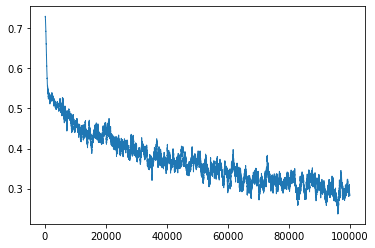

In [42]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [43]:
loss = None
cleanup()
model.eval();

In [44]:
eval_bs = 16

In [45]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

  0%|          | 0/109 [00:00<?, ?it/s]

0.8196607288498625


In [68]:
model.save_pretrained('../models/bak-ru-cross-v1');

In [63]:
data_val['predicted_score'] = logits

In [65]:
def get_status(row):
    if row.predicted_score >= 0.5:
        return 'TP' if row.is_correct else 'FP'
    else:
        return 'FN' if row.is_correct else 'TN'


data_val['status'] = data_val.apply(get_status, axis=1)

In [66]:
data_val.groupby('status').sample(2)

,date,ba,ru,is_correct,data_split,predicted_score,status
37184,22/11/2021 05:18:53,Мин һеҙгә ярҙам итермен. Айыуҙарҙы йыйырмын.,Я-я помогать вам буду.,1,val,0.077150,FN
2252,22/09/2021 19:25:25,"Әбейҙәр, нимәлер булһа ла ҡалғандыр, бәлки, ул...","Бабки, кляня судьбу, направились к пепелищу в ...",1,val,0.067478,FN
140708,02/10/2021 14:02:37,Теләгән инженерлыҡҡа уҡырға – уҡыған.,Баязит захотел выучиться на инженера – выучился.,0,val,0.966105,FP
138253,22/09/2021 09:43:36,"– Ҡыҙый, үлдеңме әллә?! – тип ҡысҡырып илап еб...",— Да живая ли ты?! – громко расплакалась я.,0,val,0.983788,FP
163683,15/11/2022 06:32:09,Көйө шәп...,— За душу берет!,0,val,0.054126,TN
163824,15/11/2022 12:36:58,Былар Емеш өсөн яңылыҡ түгелдәр ҙә.,На матице висела небогатая одежда.,0,val,0.185397,TN
68839,11/08/2022 11:15:37,Түгел.,Нет.,1,val,0.975845,TP
72744,19/08/2022 21:43:55,Емеш бит – кеше.,А Емеш – человек.,1,val,0.984550,TP


In [67]:
data_val.to_csv('../data/validation_split_with_scores_v1.tsv', sep='\t', index=None)

The stabilized training doesn't seem to help. What about longer training?

In [47]:
optimizer.param_groups[0]['lr'] = 1e-5

In [50]:
more_steps = 300_000

In [51]:
model.train()
tq = trange(len(losses), more_steps)
for i in tq:
    pp, pl = get_pairs_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        # scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/200000 [00:00<?, ?it/s]

100000 0.2314740815013647
100100 0.328120159804821
100200 0.33703245151787997
100300 0.35262558616697787
100400 0.30640911173075436
100500 0.354770477861166
100600 0.3816807674616575
100700 0.342901039943099
100800 0.3207751985639334
100900 0.3032588380202651
101000 0.3339321431517601
101100 0.3264063729718327
101200 0.3346262264624238
error 567
101300 0.31851371757686137
error 314
101400 0.27929306037724017
101500 0.32247315119951964
101600 0.35245270453393457
101700 0.39685261618345974
101800 0.303269666172564
101900 0.3175062459334731
102000 0.4146667254343629
102100 0.29192152999341486
102200 0.3379116972535849
102300 0.25977012123912574
102400 0.3343113375082612
102500 0.3313559988513589
102600 0.38369728628546
102700 0.4079817347228527
102800 0.32383900467306376
102900 0.40492324948310854
103000 0.3497805513814092
103100 0.3853456811606884
103200 0.34765087351202967
103300 0.35136662412434816
103400 0.4052456574887037
103500 0.33815195951610805
103600 0.3112677585333586
103700 0.

130800 0.3403628747537732
130900 0.3075614544376731
131000 0.24039021786302328
131100 0.26319392330944535
131200 0.3604154746979475
131300 0.2944960697367787
131400 0.31073705047369005
131500 0.28701724600046874
131600 0.31940249741077426
131700 0.31639173232018947
131800 0.32189844392240047
131900 0.3680140994116664
132000 0.3113299233838916
132100 0.2263446342200041
132200 0.3216846000030637
132300 0.35425632424652576
132400 0.31641053535044195
132500 0.2980633495002985
132600 0.30980360332876444
132700 0.34288535922765734
132800 0.2896596631407738
132900 0.32957917284220456
133000 0.27862583175301553
133100 0.29489815548062326
133200 0.2747848343104124
133300 0.2755894860997796
133400 0.2827678173407912
133500 0.35414616417139766
133600 0.30761509623378513
133700 0.38157402254641054
133800 0.27683865413069725
133900 0.31494892086833715
134000 0.2494838520511985
134100 0.35971456181257966
134200 0.3123298342898488
134300 0.27836467020213607
134400 0.25261303786188366
134500 0.3775084

161600 0.25595274746418
161700 0.2860791106522083
161800 0.21597356259822845
161900 0.23368932243436574
162000 0.29261637903749943
162100 0.30399832502007484
162200 0.2564335925504565
162300 0.33960614204406736
162400 0.35381309397518634
162500 0.1931772942468524
162600 0.18380352705717087
162700 0.2541572395712137
162800 0.22118665143847466
162900 0.30078039348125457
163000 0.31605420365929604
163100 0.19156250707805156
163200 0.21427449446171523
163300 0.27195520389825106
163400 0.29523507088422773
163500 0.2630819972977042
163600 0.2593648072704673
163700 0.2905106853321195
163800 0.2746760661527514
163900 0.2515474441275001
164000 0.21589096080511808
164100 0.2051966365426779
164200 0.2534907392039895
164300 0.33440186973661185
164400 0.269102904163301
error 411
164500 0.24093467101454735
164600 0.2670256699994206
164700 0.2905655200779438
164800 0.2996565503254533
164900 0.2414167033880949
165000 0.26827597338706255
165100 0.232986743375659
165200 0.27973314814269545
165300 0.2363

192300 0.2182553792744875
192400 0.30157295919954774
192500 0.18262874674052
192600 0.20878452975302936
192700 0.19058395586907864
192800 0.22137260016053914
192900 0.20287756148725747
193000 0.22003083102405072
193100 0.26290934048593045
193200 0.1629001033306122
193300 0.1802746820449829
193400 0.1830286328494549
193500 0.19937933433800936
193600 0.27925964407622816
193700 0.25589693777263167
193800 0.2200662460178137
193900 0.2370350246876478
194000 0.24139880634844302
194100 0.18490397684276105
194200 0.1981206538900733
194300 0.25624868731945755
194400 0.21287404503673316
194500 0.17621390655636787
194600 0.21307843867689372
194700 0.18267768304795026
194800 0.22062541510909794
194900 0.3098310352116823
195000 0.27225653640925884
195100 0.20997191969305276
195200 0.21148593939840793
195300 0.20903511706739664
195400 0.2980722601339221
195500 0.2501703868061304
195600 0.30553383599966766
195700 0.19257775533944368
195800 0.2838886770606041
195900 0.24718687042593956
196000 0.252773

223200 0.13753405012190342
223300 0.23462959494441749
223400 0.23905245527625085
223500 0.19273839090019465
223600 0.1802529102563858
223700 0.25256106212735174
223800 0.22934311777353286
223900 0.2042713164165616
224000 0.19905116733163594
224100 0.20927886199206114
224200 0.22011194236576556
224300 0.2066635734960437
224400 0.21687406674027443
224500 0.20757542718201877
224600 0.24698856264352798
224700 0.24631157651543617
224800 0.23252474401146173
224900 0.22738958090543748
225000 0.2152229779958725
225100 0.1342868159338832
225200 0.20007785815745593
225300 0.24206149898469448
225400 0.2071124456822872
225500 0.2775802705809474
225600 0.2399595706537366
225700 0.22788811933249234
225800 0.19497260838747024
225900 0.23157180730253457
226000 0.18400989446789026
226100 0.2627025888487697
226200 0.2004656420275569
226300 0.25303173266351225
226400 0.1622143021225929
226500 0.22216592479497194
226600 0.20691306598484516
226700 0.21157337956130504
226800 0.2399469058215618
226900 0.1836

254000 0.2844189640507102
254100 0.2983200401067734
254200 0.23073815200477837
254300 0.1850259467586875
254400 0.14027916081249714
254500 0.29428864534944293
254600 0.15578159615397452
254700 0.25411057770252227
254800 0.14350876275449992
254900 0.1959894123673439
255000 0.2535718810930848
255100 0.15197028294205667
255200 0.1634228339791298
255300 0.1892599306255579
255400 0.2709896293282509
255500 0.1085949856042862
255600 0.22616233792155982
255700 0.10583646725863219
255800 0.17281242359429597
255900 0.2287398263067007
256000 0.1787790536507964
256100 0.20345961190760137
256200 0.2200953497737646
256300 0.21505839858204126
256400 0.2674107818305492
256500 0.1976944572106004
256600 0.1476677578687668
256700 0.16057491555809975
256800 0.2077776398137212
256900 0.259988409280777
257000 0.18877569925040005
257100 0.22403643645346163
257200 0.1424650177359581
257300 0.13705646246671677
257400 0.18543280061334372
257500 0.16511782679706813
257600 0.19267740439623593
257700 0.19565464921

284800 0.15551586028188466
284900 0.14921140152961015
285000 0.1694597016647458
285100 0.19681038599461317
285200 0.20681563120335342
285300 0.15124764017760753
285400 0.2030704164877534
285500 0.20846720833331348
285600 0.17099197022616863
285700 0.20969102181494237
285800 0.16746258947998285
285900 0.17091797221452
286000 0.18323130998760462
286100 0.2697598929330707
286200 0.144522484280169
286300 0.1925813803821802
286400 0.19088731076568366
286500 0.17237230595201253
286600 0.1670593437552452
286700 0.1511813312023878
286800 0.1382428013533354
286900 0.22060762852430343
287000 0.1925974415615201
287100 0.18242407619953155
287200 0.17252658508718013
287300 0.1574372374266386
287400 0.12433795016258956
287500 0.15199119478464126
287600 0.2083512932062149
287700 0.14131392955780028
287800 0.14042689356952906
287900 0.24342177782207727
288000 0.1653849770501256
288100 0.16872134760022164
288200 0.1251394420862198
288300 0.17056458700448274
288400 0.1891435020789504
288500 0.1698896479

In [52]:
loss = None
cleanup()
model.eval();

In [53]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

  0%|          | 0/109 [00:00<?, ?it/s]

0.7901774484919164


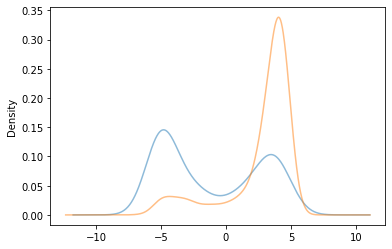

In [54]:
pd.Series(np.log(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(alpha=0.5, kind='kde');

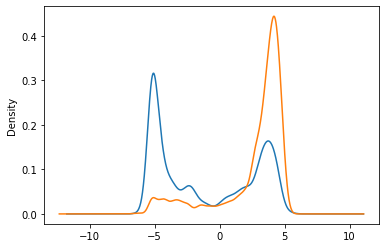

In [56]:
pd.Series(np.log(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [61]:
print(data_val.is_correct.mean())
print(logits.mean())
print((logits>0.5).mean())

0.7779690189328744
0.74031645
0.7636259323006311


By filtering, we can easily filter out about 1/2 or 2/3 of bad pairs. 

However, the resulting bad pairs are really difficult to detect. 

In [87]:
threshold = np.quantile(logits, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (logits < threshold)[data_val.is_correct.values==0].mean())

recall@ ideal reject rate: 0.5607235142118863


In [70]:
data_val.is_correct.groupby(['accepted' if l > 0.1 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,189,1214
rejected,198,142


In [66]:
data_val.is_correct.groupby(['accepted' if l > 0.5 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,165,1166
rejected,222,190


In [67]:
data_val.is_correct.groupby(['accepted' if l > 0.9 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,125,1055
rejected,262,301


In [69]:
data_val.is_correct.groupby(['accepted' if l > 0.98 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,47,590
rejected,340,766
